# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you):
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

You have to report all your work at the end of this notebook.



# Code

In [1]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.

    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector

    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers

    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.

    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)

    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.

    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """

    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]

    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset

    :model: Model to be fit
    :X_train, y_train: Train samples and labels
    :X_test y_test: Test samples and labels
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """

    # Train the model
    history=model.fit(X_train, y_train,
                      validation_split= 0.1,
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])

    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')

    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()


def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):

    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

    states = [encoder_state_h, encoder_state_c]

    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')

    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))

    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h

    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        outputs = decoder_dense(decoder_outputs)

        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)

        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model, encoder_lstm, decoder_lstm, decoder_dense




class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis,
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



In [7]:
# dataset
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()

In [ ]:
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/150
18/18 [==============================] - 170s 2s/step - loss: 2.9632 - accuracy: 0.0536 - val_loss: 2.9465 - val_accuracy: 0.0527
Epoch 2/150
18/18 [==============================] - 5s 262ms/step - loss: 2.9452 - accuracy: 0.0554 - val_loss: 2.9447 - val_accuracy: 0.0539
Epoch 3/150
18/18 [==============================] - 5s 261ms/step - loss: 2.9420 - accuracy: 0.0633 - val_loss: 2.9446 - val_accuracy: 0.0624
Epoch 4/150
18/18 [==============================] - 5s 262ms/step - loss: 2.9415 - accuracy: 0.0636 - val_loss: 2.9399 - val_accuracy: 0.0663
Epoch 5/150
18/18 [==============================] - 5s 256ms/step - loss: 2.9344 - accuracy: 0.0723 - val_loss: 2.9286 - val_accuracy: 0.0739
Epoch 6/150
18/18 [==============================] - 5s 261ms/step - loss: 2.9257 - accuracy: 0.0770 - val_loss: 2.9221 - val_accuracy: 0.0771
Epoch 7/150
18/18 [==============================] - 5s 257ms/step - loss: 2.9173 - accuracy: 0.0822 - val_loss: 2.9115 - val_accuracy: 0.0858


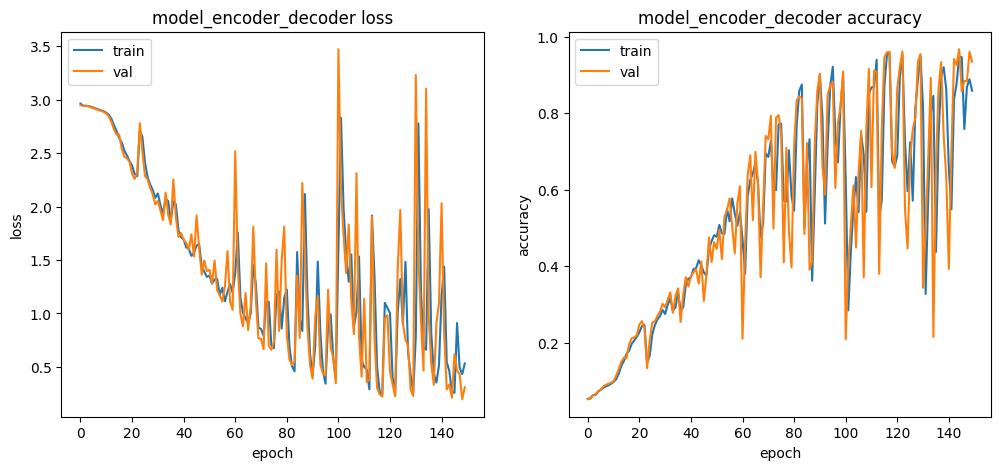

In [ ]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=150, patience=100)

##Bahdanau and Luong General Attention Implementations

Here, we implemet the formulas for the score function, by initialazing the weights and other terms involved in the following score function. Then when we call it, we broaden dimensions to incorporate time, calculate the score, determine weights, and derive the context vector.

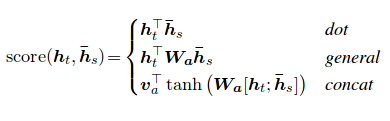

In [4]:
class BahdanauAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super(BahdanauAttention, self).__init__()

        ##################
        # YOUR CODE HERE #
        ##################

        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)


    def call(self, query, values):
        ##################
        # YOUR CODE HERE #
        ##################

        # query shape == (batch_size, hidden_size)
        # values shape == (batch_size, max_length, hidden_size)

        # Expand dimensions to add a batch size dimension to the query
        query_with_time_axis = tf.expand_dims(query, 1)

        # Score calculation using the Bahdanau formula
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [5]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()

        ##################
        # YOUR CODE HERE #
        ##################

        self.W = tf.keras.layers.Dense(units)


    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        ##################
        # YOUR CODE HERE #
        ##################

        # Expand dimensions to add a batch size dimension to the query
        query_with_time_axis = tf.expand_dims(query, 1)

        # Apply the linear layer to the query
        query_processed = self.W(query_with_time_axis)

        # Score calculation using the dot product
        score = tf.matmul(values, query_processed, transpose_b=True)

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)


        return context_vector, attention_weights

##Training the model as before

In [8]:
# attention model for LuongDotAttention
attention_ld = LuongDotAttention()
model_attention, encoder_lstm_ld, decoder_lstm_ld, decoder_dense_ld = build_attention_model(attention, batch_size, rnn_units)


Epoch 1/200
18/18 [==============================] - 177s 2s/step - loss: 2.9666 - accuracy: 0.0551 - val_loss: 2.9489 - val_accuracy: 0.0532
Epoch 2/200
18/18 [==============================] - 5s 264ms/step - loss: 2.9456 - accuracy: 0.0552 - val_loss: 2.9438 - val_accuracy: 0.0520
Epoch 3/200
18/18 [==============================] - 5s 285ms/step - loss: 2.9401 - accuracy: 0.0630 - val_loss: 2.9437 - val_accuracy: 0.0651
Epoch 4/200
18/18 [==============================] - 5s 254ms/step - loss: 2.9351 - accuracy: 0.0714 - val_loss: 2.9289 - val_accuracy: 0.0754
Epoch 5/200
18/18 [==============================] - 5s 254ms/step - loss: 2.9243 - accuracy: 0.0776 - val_loss: 2.9176 - val_accuracy: 0.0788
Epoch 6/200
18/18 [==============================] - 5s 267ms/step - loss: 2.9131 - accuracy: 0.0830 - val_loss: 2.9073 - val_accuracy: 0.0859
Epoch 7/200
18/18 [==============================] - 5s 255ms/step - loss: 2.9041 - accuracy: 0.0877 - val_loss: 2.9006 - val_accuracy: 0.0880


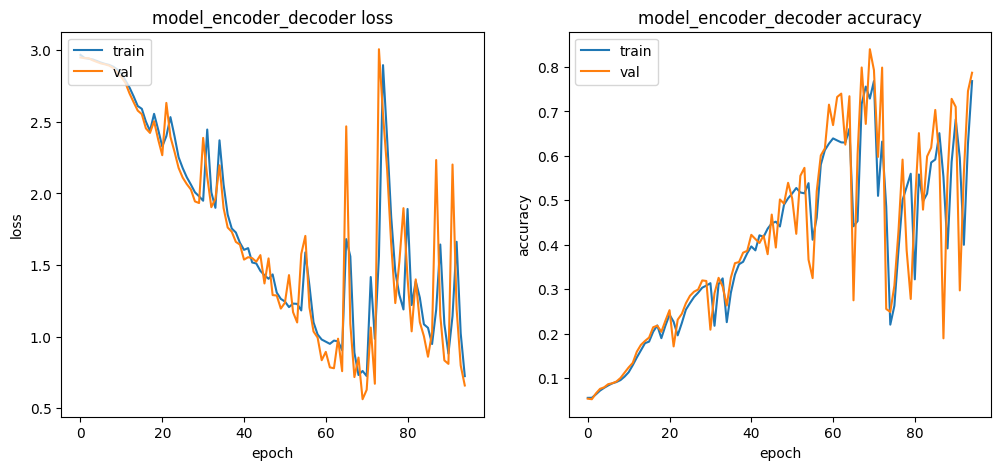

In [9]:
#training
train_test(model_attention, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=25)

In [10]:
# Train BahdanauAttention and retrieve model, encoder and decoders
attention_b = BahdanauAttention(rnn_units)
model_attention, encoder_lstm_b, decoder_lstm_b, decoder_dense_b = build_attention_model(attention_b, batch_size, rnn_units)

Epoch 1/200
18/18 [==============================] - 202s 3s/step - loss: 2.9627 - accuracy: 0.0536 - val_loss: 2.9464 - val_accuracy: 0.0520
Epoch 2/200
18/18 [==============================] - 14s 803ms/step - loss: 2.9453 - accuracy: 0.0561 - val_loss: 2.9447 - val_accuracy: 0.0548
Epoch 3/200
18/18 [==============================] - 15s 826ms/step - loss: 2.9421 - accuracy: 0.0622 - val_loss: 2.9417 - val_accuracy: 0.0596
Epoch 4/200
18/18 [==============================] - 15s 813ms/step - loss: 2.9372 - accuracy: 0.0672 - val_loss: 2.9341 - val_accuracy: 0.0699
Epoch 5/200
18/18 [==============================] - 14s 796ms/step - loss: 2.9294 - accuracy: 0.0744 - val_loss: 2.9235 - val_accuracy: 0.0795
Epoch 6/200
18/18 [==============================] - 14s 793ms/step - loss: 2.9191 - accuracy: 0.0799 - val_loss: 2.9120 - val_accuracy: 0.0851
Epoch 7/200
18/18 [==============================] - 14s 798ms/step - loss: 2.9063 - accuracy: 0.0862 - val_loss: 2.9018 - val_accuracy: 0

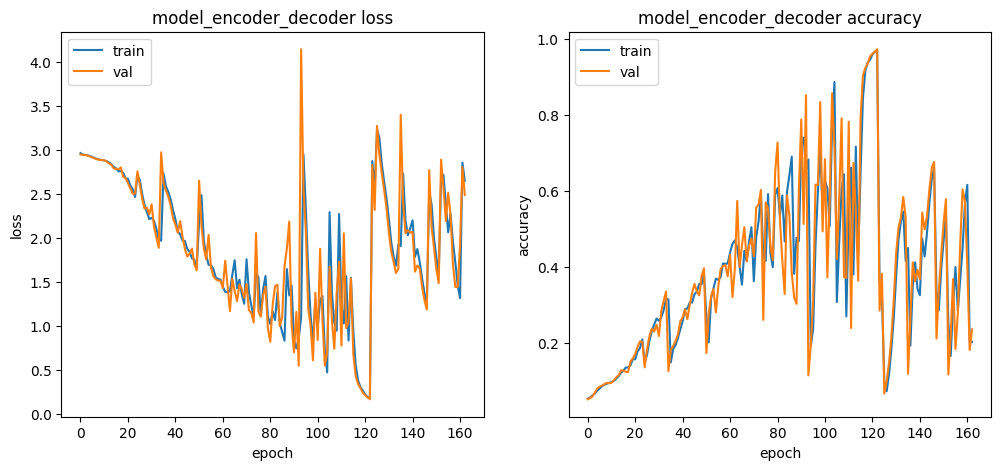

In [ ]:
train_test(model_attention, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=40)


In [11]:
# Train LuongGeneralAttention and retrieve model, encoder and decoders
attention_lg = LuongGeneralAttention(rnn_units)
model_attention, encoder_lstm_lg, decoder_lstm_lg, decoder_dense_lg = build_attention_model(attention_lg, batch_size, rnn_units)


Epoch 1/200
18/18 [==============================] - 178s 3s/step - loss: 2.9663 - accuracy: 0.0543 - val_loss: 2.9469 - val_accuracy: 0.0612
Epoch 2/200
18/18 [==============================] - 5s 302ms/step - loss: 2.9454 - accuracy: 0.0583 - val_loss: 2.9441 - val_accuracy: 0.0619
Epoch 3/200
18/18 [==============================] - 5s 300ms/step - loss: 2.9415 - accuracy: 0.0606 - val_loss: 2.9419 - val_accuracy: 0.0638
Epoch 4/200
18/18 [==============================] - 5s 300ms/step - loss: 2.9371 - accuracy: 0.0687 - val_loss: 2.9337 - val_accuracy: 0.0709
Epoch 5/200
18/18 [==============================] - 5s 298ms/step - loss: 2.9292 - accuracy: 0.0735 - val_loss: 2.9254 - val_accuracy: 0.0753
Epoch 6/200
18/18 [==============================] - 5s 294ms/step - loss: 2.9206 - accuracy: 0.0789 - val_loss: 2.9162 - val_accuracy: 0.0816
Epoch 7/200
18/18 [==============================] - 5s 306ms/step - loss: 2.9128 - accuracy: 0.0829 - val_loss: 2.9105 - val_accuracy: 0.0844


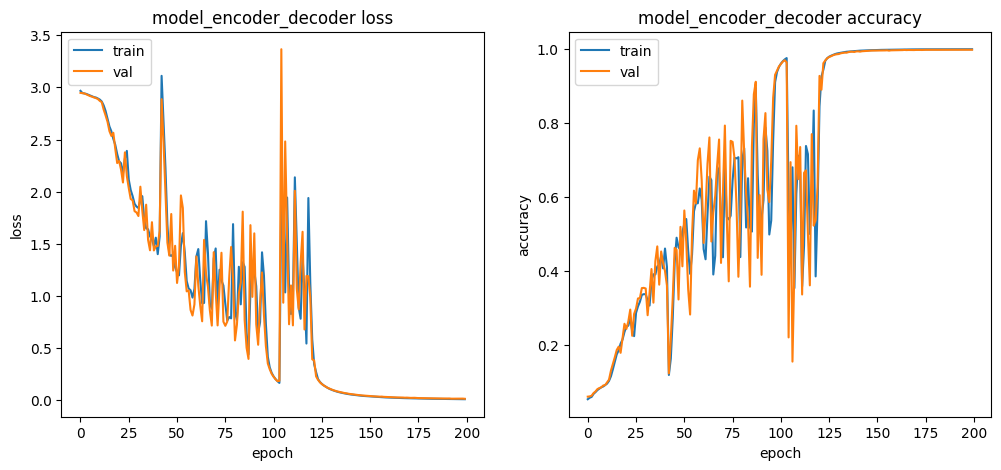

In [12]:
train_test(model_attention, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=25)


## Visualization

To visualize the weights as needed, we must developed certain utilities. Initially, it is essential to implement modifications in the return values of specified functions to retrieve distinct encoders and decoders.

The translate method assumes the responsibility of initiating the translation process through a model evaluation method, primarily builr upon the build_attention_model method. Additionally, it is responsible for invoking the method that displays the intended plots.

In [13]:
def evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  # Initialize the attention plotting for visualization and enconde input sequence
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  sequence = one_hot_encode(seq_in,n_features)

  # ENCODER STEP (Remember we don't need to initialize it because they are given)
  encoder_inputs = np.array(sequence).reshape(1,n_timesteps_in,n_features)
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

  states = [encoder_state_h, encoder_state_c]

  all_outputs = []

  # DECODER STEP
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1
  inputs = decoder_input_data
  decoder_outputs = encoder_state_h

  # Same loop as in build_attention_model. Decoder will only process one timestep at a time.
  for t in range(n_timesteps_in):
      # Pay attention
      # Create the context vector by applying attention to the outputs.
      context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
      context_vector = tf.expand_dims(context_vector, 1)

      # Concatenate the input + context vectore to find the next decoder's input
      inputs = tf.concat([context_vector, inputs], axis=-1)

      # Storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()

      # Passing the concatenated vector to the LSTM
      # Run the decoder on one timestep and previous states
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)
      decoder_outputs, encoder_state_h, encoder_state_c = decoder_lstm(inputs, initial_state=states)
      outputs = decoder_dense(decoder_outputs)

      # Use the last hidden state for prediction the output, save the current prediction
      # Predictions will be concatenated later
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)

      # Reinject the outputs as inputs for the next loop iteration as well as update the states
      inputs = outputs
      states = [encoder_state_h, encoder_state_c]

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  seq_out=one_hot_decode(decoder_outputs[0])

  return seq_in, seq_out, attention_plot

In [14]:
import matplotlib.ticker as ticker

def plot_attention(attention, sequence, predicted_sequence):
  fig = plt.figure(figsize=(16,16))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  # add labels
  fontdict = {'fontsize': 10}
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [15]:
def translate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  seq_in, seq_out, attention_plot = evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention)
  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out)

Let's now plot for each of the following models: LuongDot, LuongGeneralBahdanau

<ipython-input-31-851cc129706d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
<ipython-input-31-851cc129706d>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)


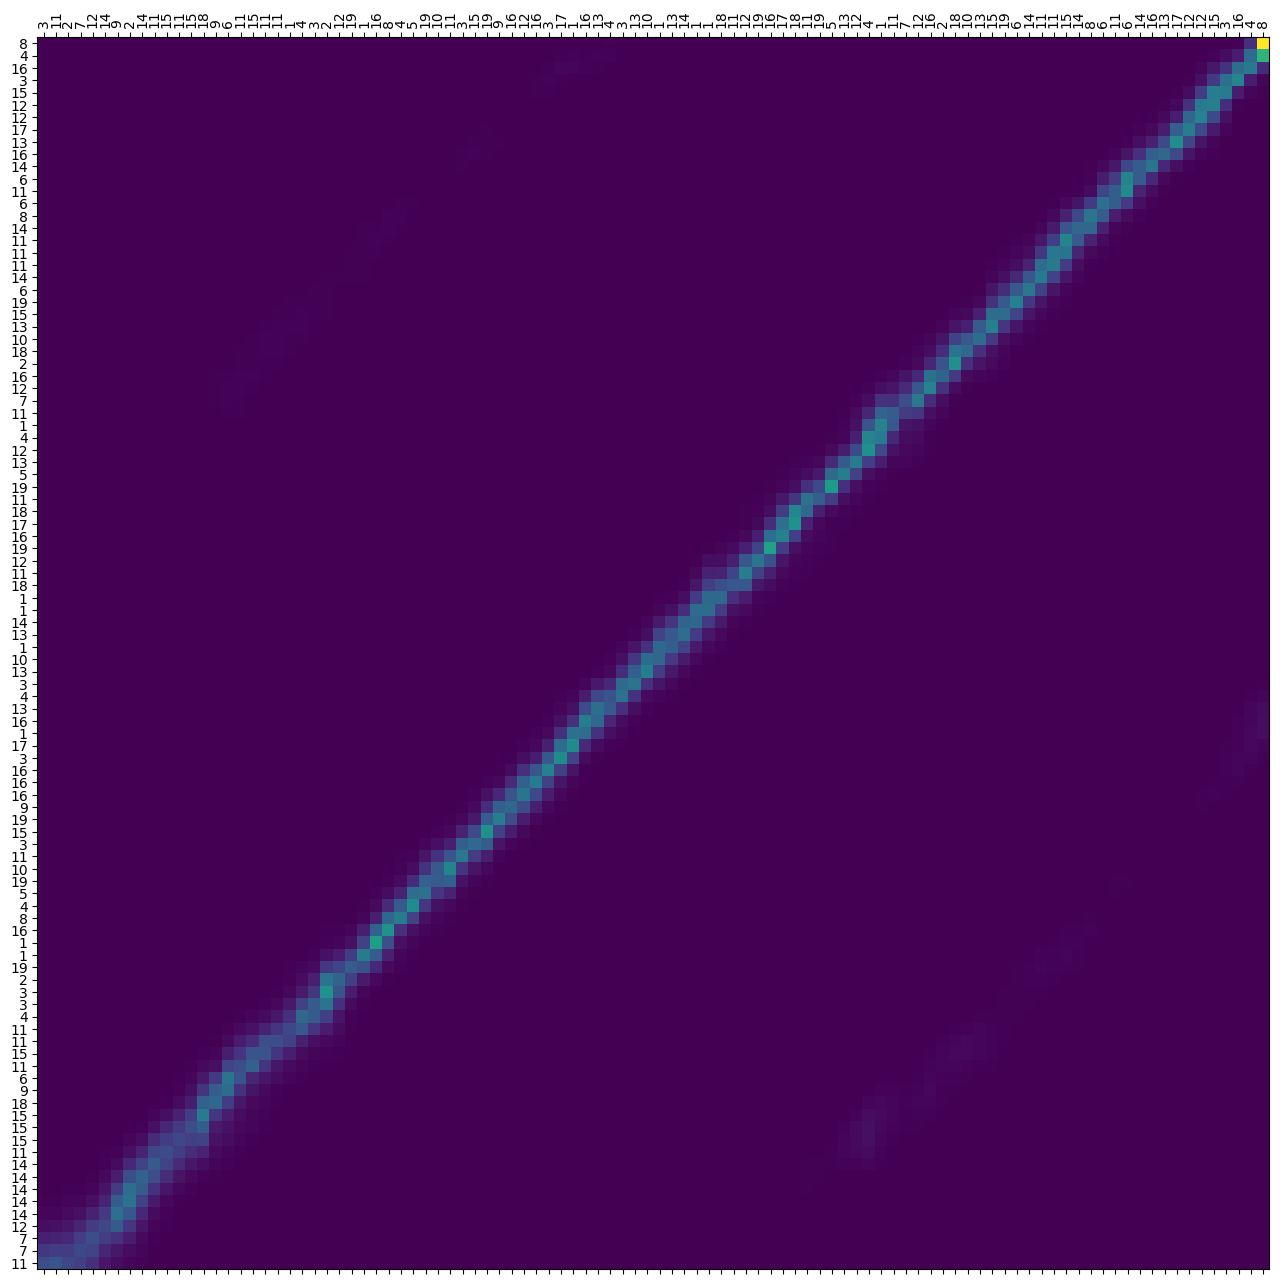

In [ ]:
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_ld, decoder_lstm_ld, decoder_dense_ld, attention_ld)


<ipython-input-31-851cc129706d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
<ipython-input-31-851cc129706d>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)


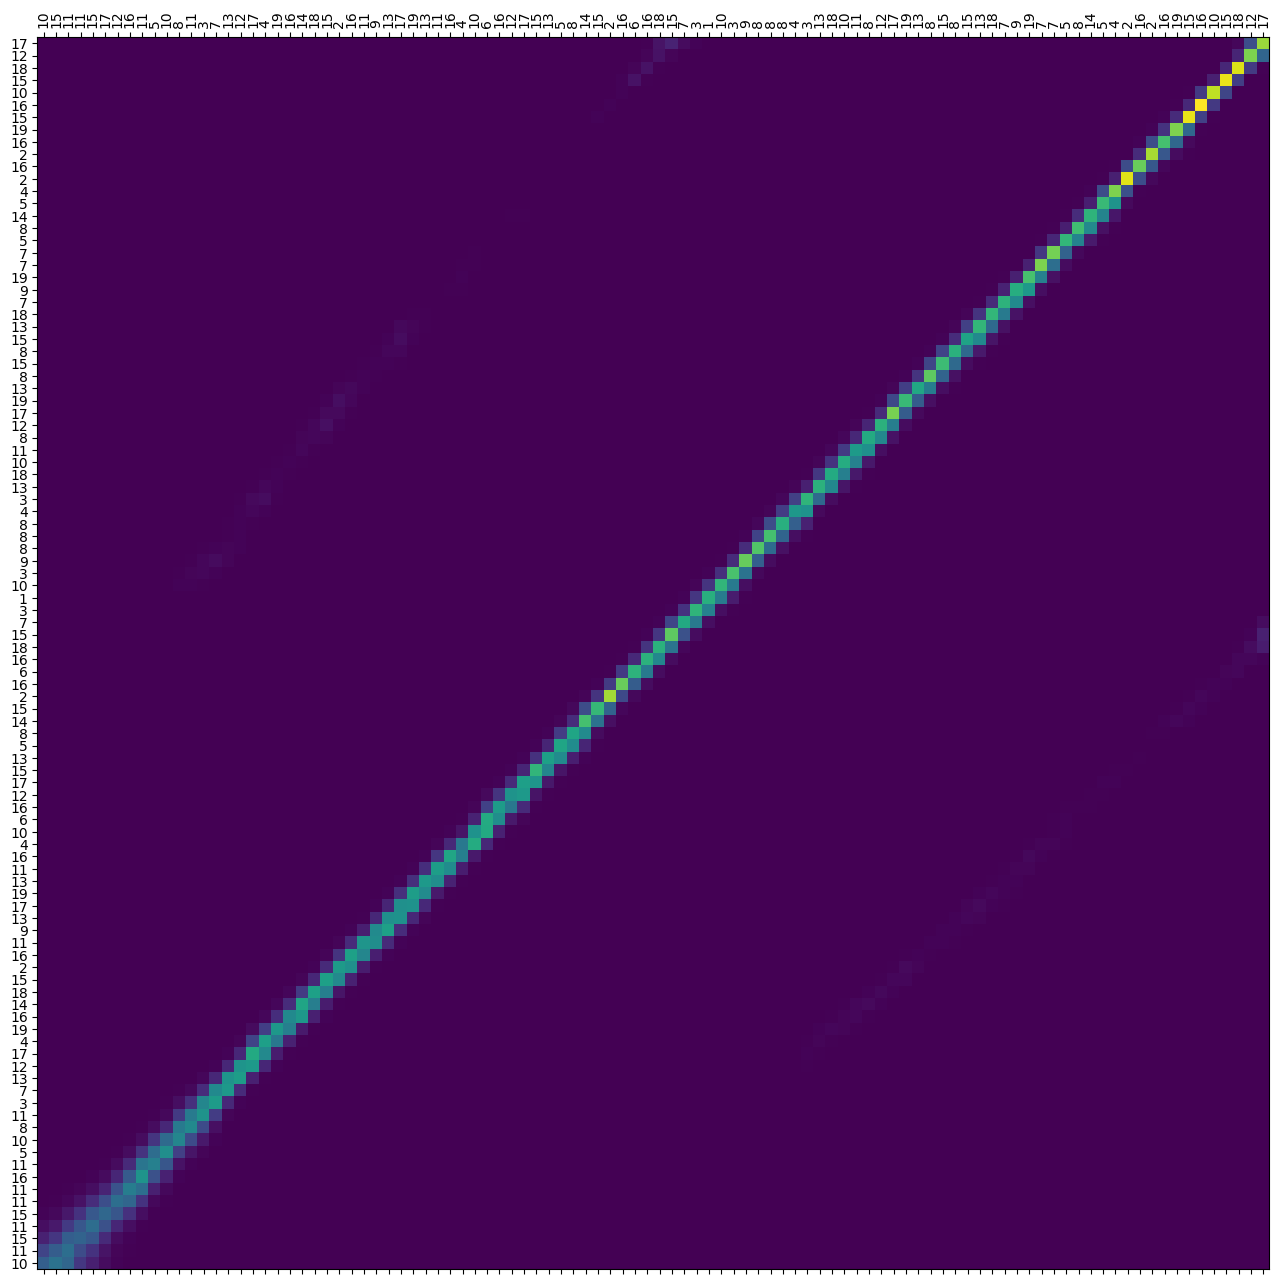

In [ ]:
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_b, decoder_lstm_b, decoder_dense_b, attention_b)


<ipython-input-14-851cc129706d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
<ipython-input-14-851cc129706d>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)


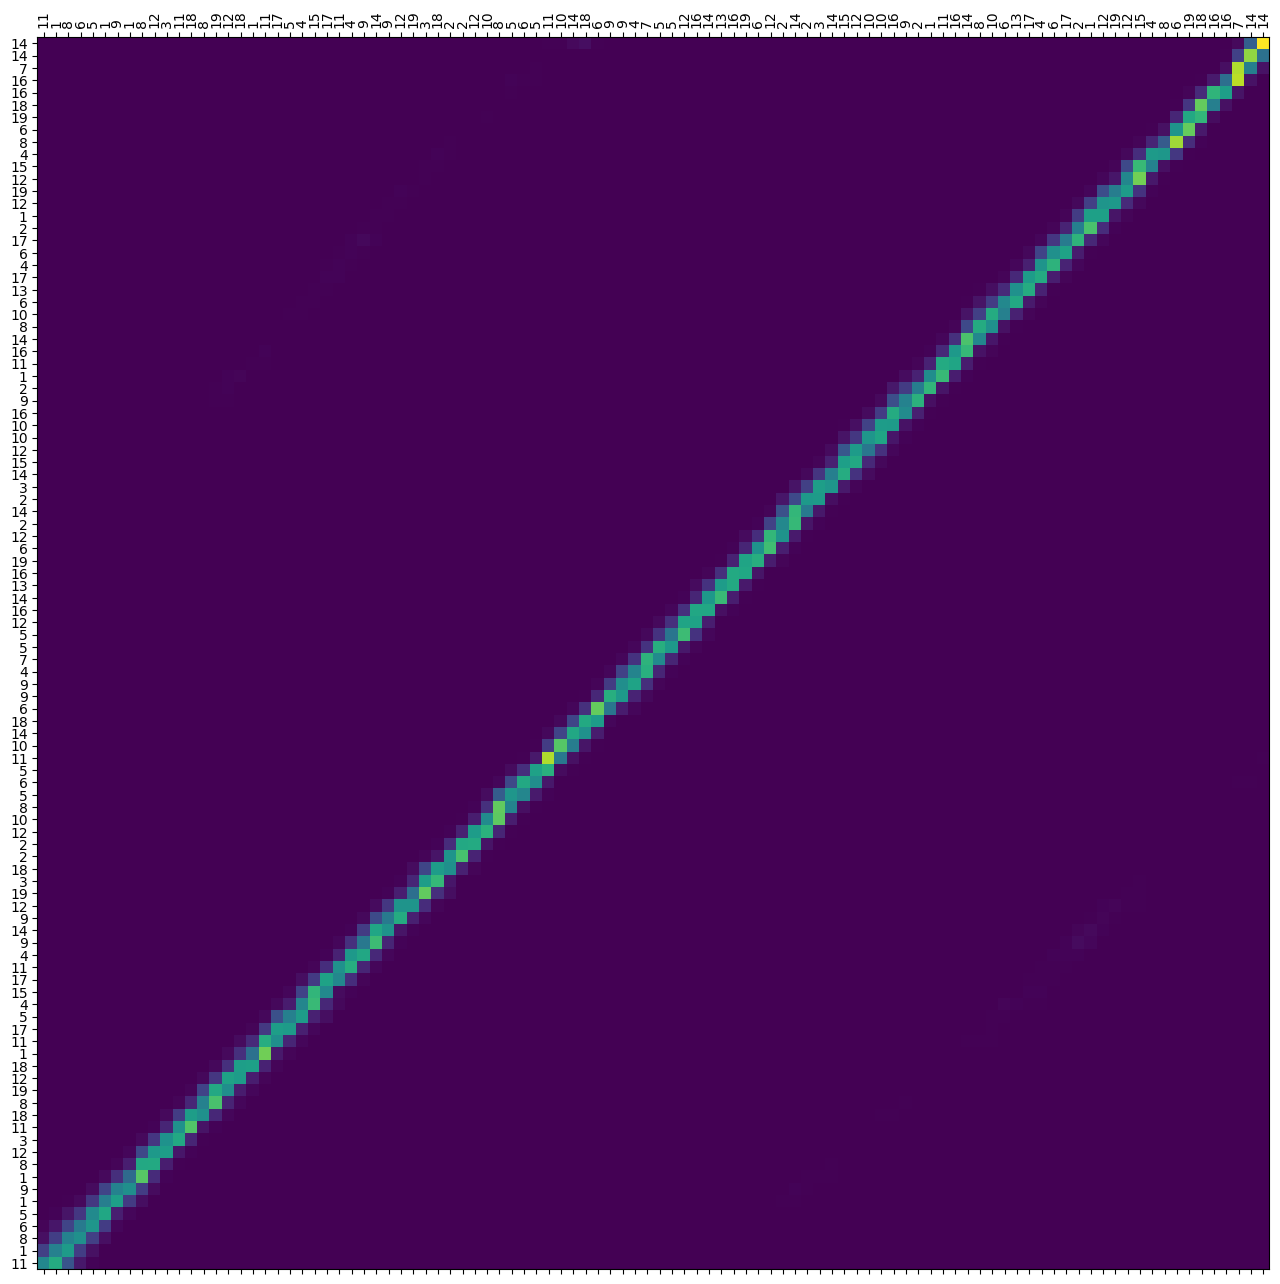

In [16]:
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_lg, decoder_lstm_lg, decoder_dense_lg, attention_lg)



Consider that the diagonal appears 'inverted' due to the ordering of the axes. The resulting structure appears to be the desired one. Although in the last experiment, an insufficient number of epochs were executed, we can assert that it is converging towards the same matrix structure for weight visualization.

##Comparative

While there are certain similarities between the global attention method and the model introduced by Bahdanau et al., notable differences underscore the simplification and generalization that have transpired.

Both the encoder and decoder employ a straightforward technique of utilizing hidden states from the uppermost LSTM layers. This involves concatenating the forward and backward source hidden states in the bi-directional encoder and the target hidden states in their non-stacking uni-directional decoder.

In the computation of the alignment vector, the Luong attention mechanism utilizes the current decoder's hidden state, whereas the Bahdanau attention mechanism relies on the previous hidden state. Furthermore, Bahdanau exclusively employs the concat score alignment model, while Luong incorporates the dot, general, and concat score alignment models.

Attention model for LuongDotAttention:

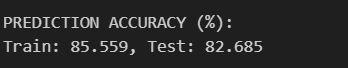

For BahdanauAttention:

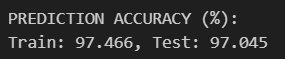

For LuongGeneralAttention:

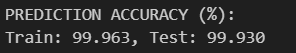

Luong General Attention would have required significalntly more epochs and time to converge and utimately achieve comparable accuracies to the other methods.

LuongDotAttention underwent retraining with the same settings as the two recently introduced attentions.

It can be observed that LuongGeneralAttention and BahnadauAttention differ in convergence times, with the latter taking longer but resulting in better generalization (higher test accuracy) than LuongDotAttention. Interestingly, both of them exhibit similar train accuracies.

Lastly, all three attention implementations yield correct weight visualization matrix structures.